# The ABIWAN file (wannier90)

This notebook shows how to use AbiPy to analyze the output files
produced by [wannier90](http://www.wannier.org/) and how to use the `ABIWAN.nc` file
produced by Abinit to interpolate band energies.

As usual, one can use:

    abiopen.py FILE_ABIWAN.nc
    
with the `--expose` or the `--print` option for a command line interface
and `--notebook` to generate a jupyter notebook.

Note: The code in this notebook requires abinit >= 8.9 and abipy >= 0.6


## Table of Contents

- [How to analyze the WOUT file](#How-to-analyze-the-WOUT-file)
- [Using ABIWAN.nc to interpolate band energies](#Using-ABIWAN.nc-to-interpolate-band-energies)

Let's start by importing the basic modules needed for this tutorial.

In [1]:
import os

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
import abipy.data as abidata

# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline   

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget  

## How to analyze the WOUT file

Use `abiopen` to open a `wout` file (the main output file produced by wannier90):

In [2]:
filepath = os.path.join(abidata.dirpath, "refs", "wannier90", "example01_gaas.wout")

wout = abilab.abiopen(filepath)
print(wout)

================================= File Info =================================
Name: example01_gaas.wout
Directory: /Users/gmatteo/git_repos/abipy/abipy/data/refs/wannier90
Size: 31.64 kb
Access Time: Wed Mar 20 16:53:47 2019
Modification Time: Wed Mar 20 16:53:35 2019
Change Time: Wed Mar 20 16:53:35 2019

================================= Structure =================================
Full Formula (Ga1 As1)
Reduced Formula: GaAs
abc   :   4.016499   4.016499   4.016499
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Ga    0     0     0
  1  As    0.25  0.25  0.25

Wannier90 version: 2.1.0+git
Number of Wannier functions: 4
K-grid: [2 2 2]

================================= WANNIERISE =================================
 iter  delta_spread  rms_gradient   spread  time     O_D     O_OD    O_TOT
    0  4.470000e+00  0.000000e+00 4.468812  0.00 0.00832 0.503629 4.468812
    1 -1.930000e-03  6.679013e-02 4.466881  0.00 0.00803 0.50

To plot the convergence of the wannier cycle use:

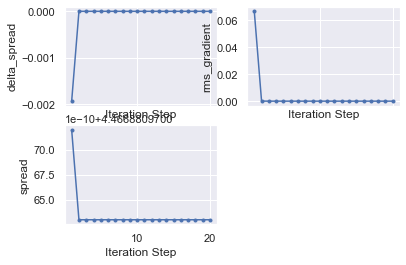

In [3]:
wout.plot();

To plot the evolution of the Wannier centers and spread, use:

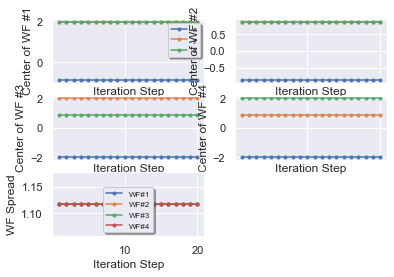

In [4]:
wout.plot_centers_spread();

<div class="alert alert-info" role="alert">
Alternatively one can use `abiopen.py FILE_MDF.nc -nb` to generate a jupyter notebook directly from the terminal
or `abiopen.py FILE_MDF.nc -e -sns` to produce matplotlib plots automatically.
</div>

## Using ABIWAN.nc to interpolate band energies


`ABIWAN.nc` is a netcdf file produced by Abinit after having called *wannier90* in library mode.
The file contains the unitary transformation and other important parameters associated to the calculations.
This file can be read by AbiPy and can be used to interpolate band energies with the wannier method.

As usual, use `abiopen` to open the file:

In [5]:
filepath = os.path.join(abidata.dirpath, "refs", "wannier90", "tutoplugs_tw90_4", "tw90_4o_DS3_ABIWAN.nc")
abiwan = abilab.abiopen(filepath)
print(abiwan)

================================= File Info =================================
Name: tw90_4o_DS3_ABIWAN.nc
Directory: /Users/gmatteo/git_repos/abipy/abipy/data/refs/wannier90/tutoplugs_tw90_4
Size: 205.47 kb
Access Time: Wed Mar 20 21:31:02 2019
Modification Time: Wed Mar 20 16:53:35 2019
Change Time: Wed Mar 20 16:53:35 2019

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.840259   3.840259   3.840259
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Si    0     0     0
  1  Si    0.25  0.25  0.25

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 24, has_timerev: False, symmorphic: False

============================== Electronic Bands ==============================
Number of electrons: 8.0, Fermi level: 5.861 (eV)
nsppol: 1, nkpt: 64, mband: 14, nspinor: 1, nspden: 1
smearing scheme: none (occopt 1), tsmear_eV: 0.272
Direct gap:
    Energ

To plot the matrix elements of the KS Hamiltonian in real space in the Wannier Gauge, use:

HWanR built in 0.009 (s)


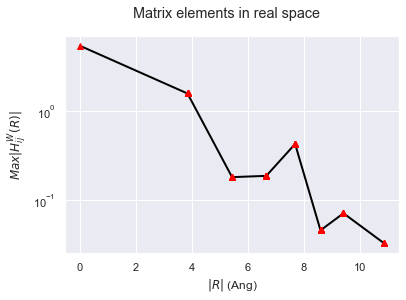

In [6]:
abiwan.hwan.plot(title="Matrix elements in real space");

To interpolate the KS energies along a high-symmetry k-path and construct 
a new `ElectronBands` object, use:

In [7]:
ebands_kpath = abiwan.interpolate_ebands()

Interpolation completed in 0.040 [s]


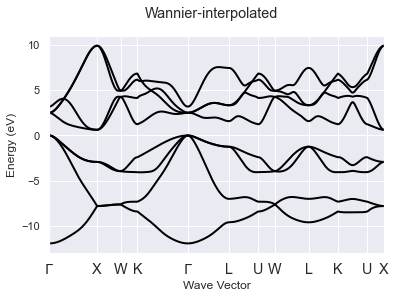

In [8]:
ebands_kpath.plot(title="Wannier-interpolated");

If you need an IBZ sampling instead of a k-path, for instance a 36x36x36 k-mesh, use:

In [9]:
ebands_kmesh = abiwan.interpolate_ebands(ngkpt=(36, 36, 36))

Interpolation completed in 0.214 [s]


As we are dealing with AbiPy objects, we can easily reuse the AbiPy API to plot bands + DOS:

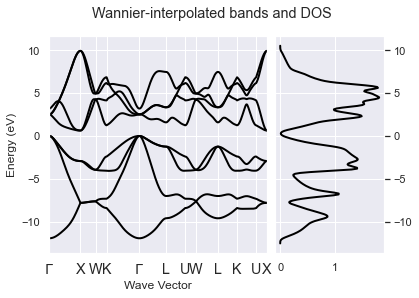

In [10]:
ebands_kpath.plot_with_edos(ebands_kmesh.get_edos(), title="Wannier-interpolated bands and DOS");

We can also compare an ab-initio band structure with the Wannier-interpolated results.
This is useful to understand if our wannier functions are well localized and if the 
k-mesh used with wannier90 is dense enough.

In this case, it is just a matter of passing the path to the netcdf file 
containing the ab-initio band structure to the `get_plotter_from_ebands` method of `abiwan`.
The function interpolates the band energies using the k-path found in the netcdf file 
and returns a plotter object:

In [11]:
import abipy.data as abidata
gsr_path = abidata.ref_file("si_nscf_GSR.nc")

plotter = abiwan.get_plotter_from_ebands(gsr_path)

Interpolation completed in 0.001 [s]


Then we call `combiplot` to plot the two band structures on the same figure:

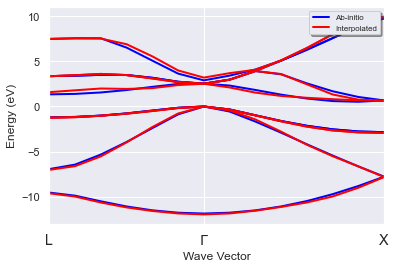

In [12]:
plotter.combiplot();

As we can see, the interpolated band structures is not completely on top of the ab-initio
results. To improve the agreement we should try to reduced the spread and/or increase 
the density of the k-mesh used in the wannierization procedure.